In [1]:
import glacierml as gl
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from scipy.stats import gaussian_kde


2023-08-30 11:53:45.207062: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-30 11:53:45.252054: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 11:53:45.939199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = gl.parameterize_data('4')
df = df.drop('RGIId', axis = 1)
# df = df.drop(['RGIId','CenLat','CenLon','Zmed','Zmax','Aspect'],axis = 1)
df = df.drop(df[df['Thickness'] >= 300].index)
df = df.reset_index()

# create a copy of df to draw K test sets to be kept in a vault
df_sampler = df.copy()
df_trainer = df.copy()

2.0.0


In [3]:
rs = 3

In [4]:
df1test = df_sampler.sample(frac = 0.25,random_state = rs)
df_sampler = df_sampler.drop(df1test.index)

df2test = df_sampler.sample(frac = 0.3333333,random_state = rs)
df_sampler = df_sampler.drop(df2test.index)

df3test = df_sampler

In [5]:
df1 = df_trainer.drop(df1test.index)
df2 = df_trainer.drop(df2test.index)
df3 = df_trainer.drop(df3test.index)

In [6]:
dnn_model = {}
model = {}
model_history = {}
results = {}
normalizer = {}

In [7]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 10,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

2/2 [==============================] - 0s 3ms/step - loss: 16.5560


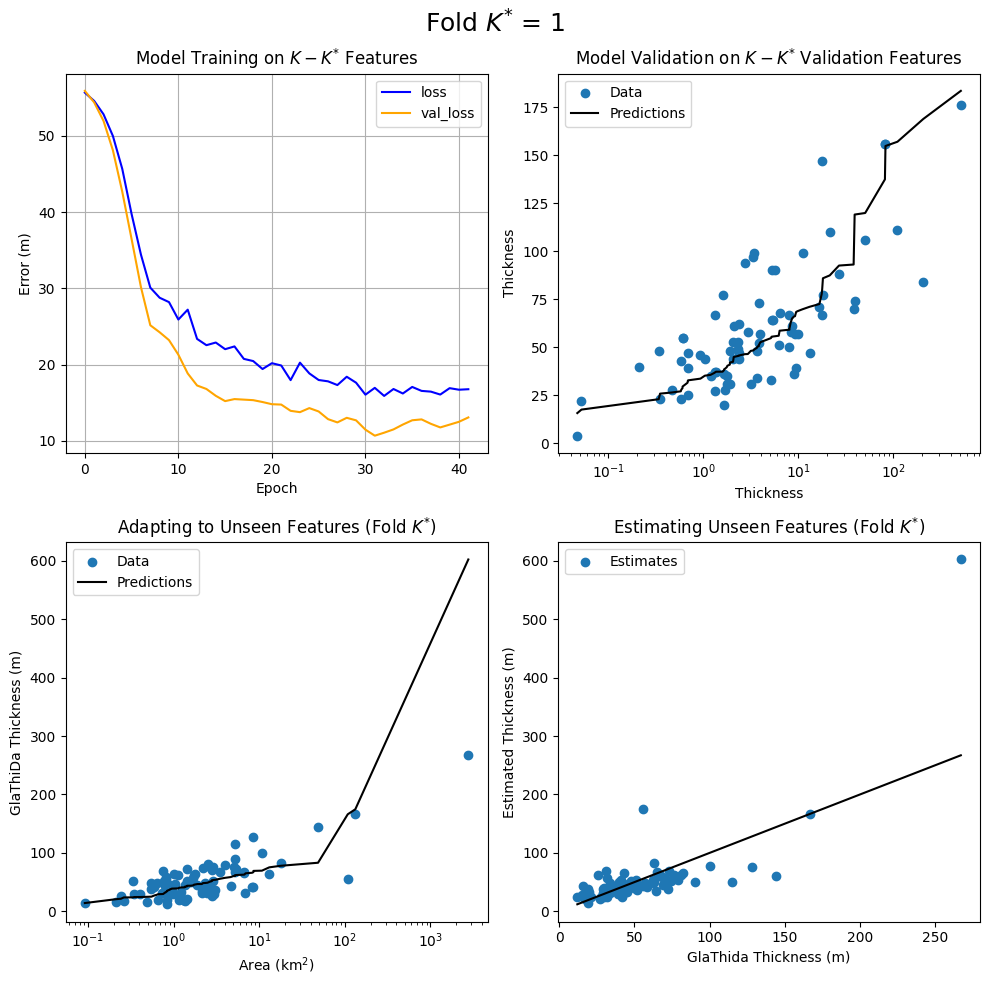

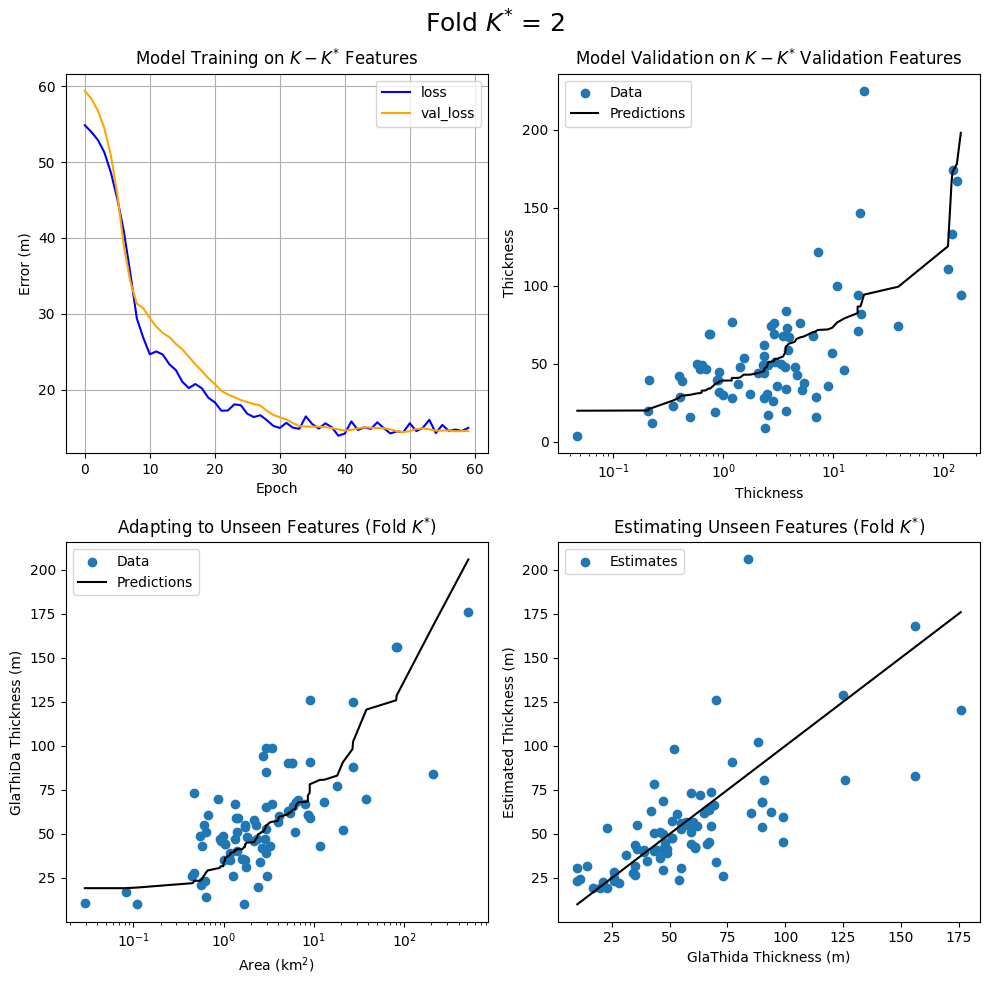

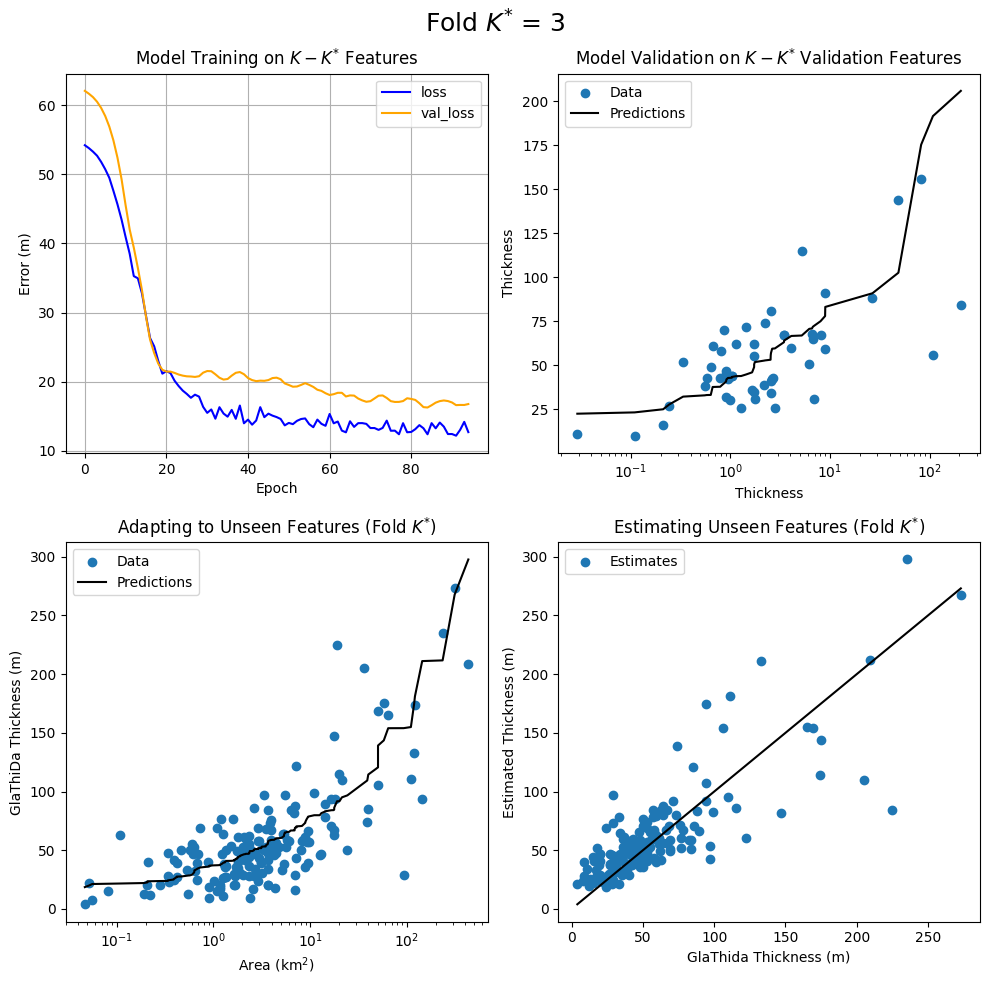

In [31]:
df_list = [df1,df2,df3]
test_df_list = [df1test,df2test,df3test]
k_list = ['1','2','3']
l1 = 13
l2 = 12
k = '1'

for k,dft,dftest in zip(k_list,df_list,test_df_list):
#     k = str(k)
#     fig, ax = plt.subplots(2,2,figsize = (10,10))
    train_features, test_features, train_labels, test_labels = gl.split_data(dft,0)
    normalizer[k] = preprocessing.Normalization(axis=-1)
    normalizer[k].adapt(np.array(train_features))

    model[k] = gl.build_dnn_model(
        normalizer[k], learning_rate = 0.01, layer_1 = l1, layer_2 = l2,loss = 'mae'
    )

    model_history[k] = model[k].fit(
        train_features,
        train_labels,
        validation_split=0.2,
        callbacks = [callback],
        verbose=0, 
        epochs=2000
    )

    
    
    #     k = str(k)
    fig, ax = plt.subplots(2,2,figsize = (10,10))
    ax[0][0].plot(
        model_history[k].history['loss'], 
         label='loss',
        color = 'blue'
    )
    ax[0][0].plot(
        model_history[k].history['val_loss'], 
        label='val_loss',
        color = 'orange'
    )
    #   plt.ylim([0, 10])
    ax[0][0].set_xlabel('Epoch')
    ax[0][0].set_ylabel('Error (m)')
    ax[0][0].legend()
    ax[0][0].grid(True)
    ax[0][0].set_title('Model Training on $K-K^{*}$ Features')
    
    
    y = model[k].predict(test_features).flatten()
    ax[0][1].scatter(test_features['Area'],test_labels,label = 'Data')
#     ax[0][1].plot(
#         test_labels.sort_values(
#         ascending = True),test_labels.sort_values(
#         ascending = True),c = 'r',label = 'Data'
#     )
    ax[0][1].plot(
        test_features['Area'].sort_values(
        ascending = True),np.sort(y),c = 'k',label = 'Predictions'
    )
    ax[0][1].set_xscale('log')
    ax[0][1].set_title('Model Validation on $K-K^{*}$ Validation Features')
    ax[0][1].set_xlabel('Thickness')
    ax[0][1].set_ylabel('Thickness')
    ax[0][1].legend()

    
    
    y = model[k].predict(dftest.drop('Thickness',axis = 1)).flatten()    
    ax[1][0].scatter(dftest['Area'],dftest['Thickness'],label = 'Data')
    ax[1][0].plot(
        dftest['Area'].sort_values(
        ascending = True),np.sort(y),c = 'k',label = 'Predictions'
    )
    ax[1][0].set_xscale('log')
    ax[1][0].set_title('Adapting to Unseen Features (Fold $K^{*}$)')
    ax[1][0].set_xlabel('Area (km$^2$)')
    ax[1][0].set_ylabel('GlaThiDa Thickness (m)')
    ax[1][0].legend()
#     plt.legend()
#     plt.show()
    
    
    
#     y = model[k].predict(dftest.drop('Thickness',axis = 1)).flatten()
    ax[1][1].scatter(dftest['Thickness'],y,label = 'Estimates')
    ax[1][1].plot(
        (dftest['Thickness'].min(),dftest['Thickness'].max()),
        (dftest['Thickness'].min(),dftest['Thickness'].max()),
        'k'
    )
    ax[1][1].set_title('Estimating Unseen Features (Fold $K^{*}$)')
    ax[1][1].set_xlabel('GlaThida Thickness (m)')
    ax[1][1].set_ylabel('Estimated Thickness (m)')
#     ax[1][1]
    fig.suptitle('Fold $K^{*}$ = ' + k,fontsize = 18)
    plt.tight_layout()
    save_title = 'xval'+k
    plt.savefig(f'img/img_{save_title}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    ax[1][1].legend(loc = 'upper left')
#     ax[0][0] = gl.plot_loss(model_history[k].history)

#     plt.show()
    results[str(l1) + '-' + str(l2) + '_'+k] = model[k].evaluate(test_features, test_labels)
y1 = 'poop'


In [33]:
res = pd.DataFrame(results,index = ['Loss']).T
res

,Loss
11-3_1,17.176464
11-3_2,18.973246
11-3_3,15.860217
12-2_1,16.001131
12-2_2,18.086420
12-2_3,18.044359
3-2_1,16.165955
3-2_2,17.905317
3-2_3,15.688876
13-12_1,16.527809


In [34]:
res.sort_values('Loss')

,Loss
3-2_3,15.688876
11-3_3,15.860217
12-2_1,16.001131
3-2_1,16.165955
13-12_1,16.527809
13-12_3,16.556023
11-3_1,17.176464
3-2_2,17.905317
12-2_3,18.044359
12-2_2,18.086420


In [10]:
res.mean()

Loss    17.336642
dtype: float64

In [32]:

# frames = []
# for k in range(1,4,1):
#     save_path = 'xval'+str(k)
#     image = imageio.v2.imread(f'img/img_{save_path}.png')
#     frames.append(image)
# imageio.mimsave('xval_example.gif', # output gif
#                 frames,          # array of input frames
#                 duration = 8000,
#                 loop = 50
#                )   

In [12]:
df

,index,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness
0,0,63.469173,-146.528168,12.0,722,1841,3081,234.583,30,41911,235.0
1,1,63.281000,-145.427000,14.0,1162,1858,2438,17.567,172,8639,147.0
2,2,58.380000,-134.349000,10.0,676,1123,1494,9.528,327,6332,66.0
3,8,61.200000,-140.302000,14.0,2145,2509,2894,5.859,341,3374,66.0
4,9,51.177000,-116.330000,15.3,2390,2526,2853,0.872,69,1181,70.0
...,...,...,...,...,...,...,...,...,...,...,...
335,489,-33.029600,-70.098400,29.0,2929,5121,5894,8.376,358,8560,59.0
336,490,-30.145400,-69.927600,29.3,4664,5187,5525,1.189,148,1596,28.0
337,491,-28.538700,-69.731800,16.0,4784,5234,5597,3.140,190,3349,39.0
338,492,-28.381400,-69.609100,11.6,5068,5406,5753,5.209,79,3782,67.0


In [13]:
y1 = model['1'].predict(df.drop('Thickness',axis = 1))
y2 = model['2'].predict(df.drop('Thickness',axis = 1))
y3 = model['3'].predict(df.drop('Thickness',axis = 1))

11/11 [==============================] - 0s 691us/step


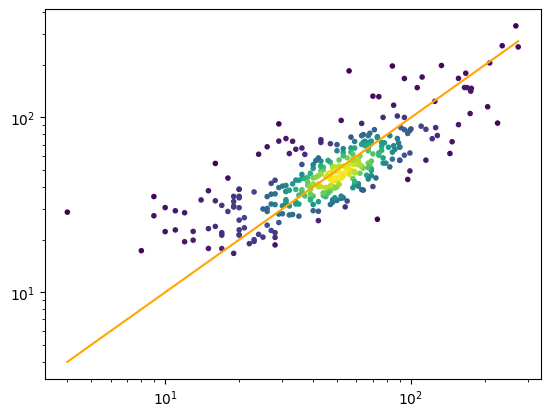

In [14]:
y_avg = ((y1 + y2 + y3) / 3).flatten()

x = df['Thickness']

xy = np.vstack([np.log10(x),np.log10(y_avg)])
z = gaussian_kde(xy)(xy)

plt.scatter(x,y_avg,c =z,cmap = 'viridis',marker = '.')
plt.plot(
    (df['Thickness'].min(),df['Thickness'].max()),
    (df['Thickness'].min(),df['Thickness'].max()),
    c = 'orange'
)
plt.xscale('log')
plt.yscale('log')